In [0]:
#Load data into a DataFrame
df = spark.table("weatherstats_calgary_daily_v2_4_csv")

In [0]:
#Drop rows with missing values
df = df.na.drop()
df.show()

+----------+---------------+---------------+---------------+---------------------+---------------------+---------------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+----+----+
|      date|max_temperature|avg_temperature|min_temperature|max_relative_humidity|avg_relative_humidity|min_relative_humidity|max_dew_point|avg_dew_point|min_dew_point|max_wind_speed|avg_wind_speed|min_wind_speed|max_visibility|avg_visibility|min_visibility|precipitation|rain|snow|
+----------+---------------+---------------+---------------+---------------------+---------------------+---------------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+----+----+
|2023-12-06|            8.7|           2.84|             -3|                   92|                 72.5|                   53|          2.6|         -0

In [0]:
#Convert Columns to Numeric Type
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

#List of columns to convert
columns_to_convert = ['max_temperature', 'min_temperature', 'avg_temperature', 
                      'max_relative_humidity', 'min_relative_humidity', 'avg_relative_humidity', 
                      'max_dew_point', 'avg_dew_point', 'min_dew_point', 
                      'max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 
                      'max_visibility', 'avg_visibility', 'min_visibility', 
                      'precipitation', 'rain', 'snow']

#Convert columns function
for column in columns_to_convert:
    df = df.withColumn(column, col(column).cast(DoubleType()))

In [0]:
#Calculate Z-Scores for Each Column
from pyspark.sql.functions import stddev, avg, col, abs

#Calculate Z-scores and attach them to a new column
for column in columns_to_convert: 
    mean_val = df.select(avg(col(column))).first()[0]
    stddev_val = df.select(stddev(col(column))).first()[0]
    df = df.withColumn(column + "_zscore", (col(column) - mean_val) / stddev_val)

In [0]:
#Filter Outliers Based on Z-scores
#Only filter out extreme outliers (Keep 95% of data)
zscore_threshold = 2 

#Filter outliers based on their Z-score column 
for column in columns_to_convert:
    df = df.filter(abs(col(column + "_zscore")) < zscore_threshold)

In [0]:
#Standardize Continuous Variables
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline

#Converting into a single vector column
assembler = VectorAssembler(inputCols=columns_to_convert, outputCol="features")
#Scaling each feature between 0-1
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

#Chain transformers and estimators 
pipeline = Pipeline(stages=[assembler, scaler])
#Apply pipeline and compute necessary statistics, then apply transformations to create a scaled dataframe
scaled_df = pipeline.fit(df).transform(df)

In [0]:
#Z-score columns that need to be dropped
zscore_columns_to_drop = [col for col in df.columns if '_zscore' in col]

#Dropped Z-score columns
final_df = df.drop(*zscore_columns_to_drop)

In [0]:
from pyspark.sql.functions import expr

#Creating a 'feels_like_temperature' feature category selection
final_df = final_df.withColumn("feels_like_temperature", 
                               expr("0.5 * (max_temperature + min_temperature) - 0.7 * avg_wind_speed"))

In [0]:
from pyspark.sql.functions import when, col

#Detailed rule-based categorization
final_df = final_df.withColumn('weather_type',
                               when((col('precipitation') > 0) & (col('precipitation') <= 2.5) & (col('snow') == 0), 'Light Rain')
                               .when((col('precipitation') > 2.5) & (col('snow') == 0), 'Heavy Rain')
                               .when((col('snow') > 0) & (col('snow') <= 2), 'Light Snow')
                               .when(col('snow') > 2, 'Snowstorm')
                               .when((col('max_visibility') > 10000) & (col('max_relative_humidity') < 60) & (col('precipitation') == 0) & (col('snow') == 0), 'Sunny')
                               .when(col('min_visibility') < 1000, 'Foggy')
                               .when((col('max_visibility') < 10000) & (col('precipitation') == 0) & (col('snow') == 0), 'Cloudy')
                               .when((col('avg_temperature') < 0) & (col('snow') == 0), 'Freezing')
                               .when((col('max_relative_humidity') > 80) & (col('precipitation') == 0) & (col('snow') == 0), 'Humid')
                               .when((col('avg_temperature') > 25) & (col('max_relative_humidity') < 50), 'Hot and Dry')
                               .when((col('avg_temperature') > 20) & (col('max_relative_humidity') > 80), 'Hot and Humid')
                               .when((col('max_wind_speed') > 15) & (col('precipitation') > 0), 'Stormy')
                               .when((col('precipitation') == 0) & (col('max_relative_humidity') < 30), 'Dry')
                               .otherwise('Other'))

In [0]:
from pyspark.ml.feature import StringIndexer

#Convert 'weather_type' column to a numeric form
indexer = StringIndexer(inputCol="weather_type", outputCol="weather_type_indexed")
featured_df = indexer.fit(final_df).transform(final_df)

#Fit the StringIndexer to the 'weather_type' column and final_df dataframe
indexer_model = StringIndexer(inputCol="weather_type", outputCol="weather_type_indexed").fit(final_df)

#View mapping of labels to indices
label_indices = indexer_model.labels
for i, label in enumerate(label_indices):
    print(f"Index {i} corresponds to weather type '{label}'")

Index 0 corresponds to weather type 'Other'
Index 1 corresponds to weather type 'Humid'
Index 2 corresponds to weather type 'Freezing'
Index 3 corresponds to weather type 'Light Rain'
Index 4 corresponds to weather type 'Sunny'
Index 5 corresponds to weather type 'Light Snow'
Index 6 corresponds to weather type 'Heavy Rain'
Index 7 corresponds to weather type 'Foggy'
Index 8 corresponds to weather type 'Cloudy'
Index 9 corresponds to weather type 'Snowstorm'


In [0]:
from pyspark.ml.feature import VectorAssembler, ChiSqSelector

#Features to include
features_to_include = ['max_temperature', 'min_temperature', 'avg_temperature', 
                       'max_relative_humidity', 'min_relative_humidity', 'avg_relative_humidity', 
                       'max_dew_point', 'avg_dew_point', 'min_dew_point', 
                       'max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 
                       'max_visibility', 'avg_visibility', 'min_visibility', 
                       'precipitation', 'rain', 'snow', 'feels_like_temperature']

#Assemble features into a vector for ML, assembled_df is the new dataframe that includes the combined feature vector
assembler = VectorAssembler(inputCols=features_to_include, outputCol="features")
assembled_df = assembler.transform(featured_df)

#Apply feature selection using the numeric label, we're using the top 10 features 
selector = ChiSqSelector(numTopFeatures=10, featuresCol="features", outputCol="selectedFeatures", labelCol="weather_type_indexed")
result = selector.fit(assembled_df).transform(assembled_df)

result.show()

+----------+---------------+---------------+---------------+---------------------+---------------------+---------------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+----+----+----------------------+------------+--------------------+--------------------+--------------------+
|      date|max_temperature|avg_temperature|min_temperature|max_relative_humidity|avg_relative_humidity|min_relative_humidity|max_dew_point|avg_dew_point|min_dew_point|max_wind_speed|avg_wind_speed|min_wind_speed|max_visibility|avg_visibility|min_visibility|precipitation|rain|snow|feels_like_temperature|weather_type|weather_type_indexed|            features|    selectedFeatures|
+----------+---------------+---------------+---------------+---------------------+---------------------+---------------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+--------

In [0]:
#Split the data into training and test sets with a 70/30 split
train_df, test_df = featured_df.randomSplit([0.7, 0.3], seed=101)

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

#Convert the label column to numeric
labelIndexer = StringIndexer(inputCol="weather_type", outputCol="label").fit(train_df)

#Assemble the features in a readable format
assembler = VectorAssembler(inputCols=features_to_include, outputCol="features")

#Create the Decision Tree model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

#Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, assembler, dt])

#Train model
model = pipeline.fit(train_df)

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [3, 5, 10]) 
             .addGrid(dt.maxBins, [20, 40, 80]) 
             .build())

#Create 5-fold CrossValidator, the training data is divided into 5 parts, then trained and evaluated 5 times
cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=MulticlassClassificationEvaluator(), 
                    numFolds=5)

#Run cross validations using different parameter combinations
cvModel = cv.fit(train_df)

#Use test dataframe to measure the accuracy of the model on new data
predictions = cvModel.transform(test_df)

#Evaluate which model was the best
evaluator = MulticlassClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)
print("Accuracy on Test Data = %g " % accuracy)

Accuracy on Test Data = 0.970085 


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Evaluate the model on test data
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

#Get accuracy, precision, recall and f1
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

#Print accuracy, precision, recall and f1
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9690265486725663
Precision: 0.9777059223961879
Recall: 0.9690265486725664
F1 Score: 0.9700847385840796


In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

#Convert DataFrame to RDD
predictionAndLabels = predictions.select("prediction", "label").rdd

#Create a metrics object for evaluating performance
metrics = MulticlassMetrics(predictionAndLabels)

#Make and print out a confusion matrix
confusionMatrix = metrics.confusionMatrix()
print("Confusion Matrix:\n", confusionMatrix.toArray())

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
 [[89.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 47.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 31.  1.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0. 21.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 13.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0. 10.  0.  0.  0.  0.]
 [ 0.  0.  0.  2.  0.  0.  4.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


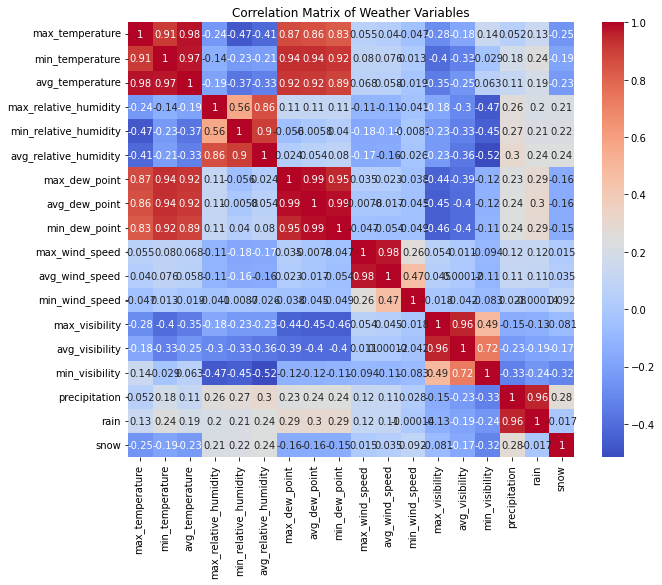

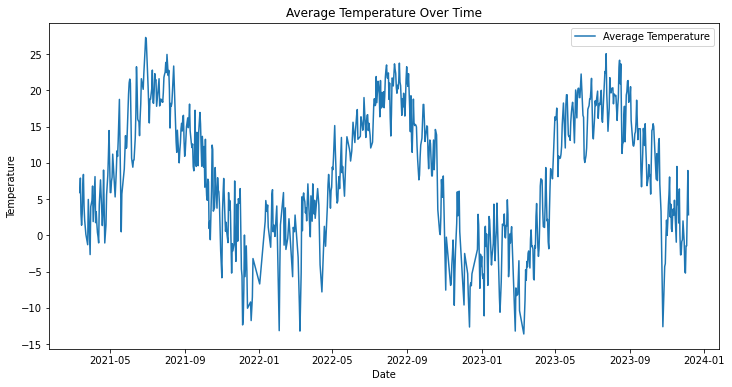

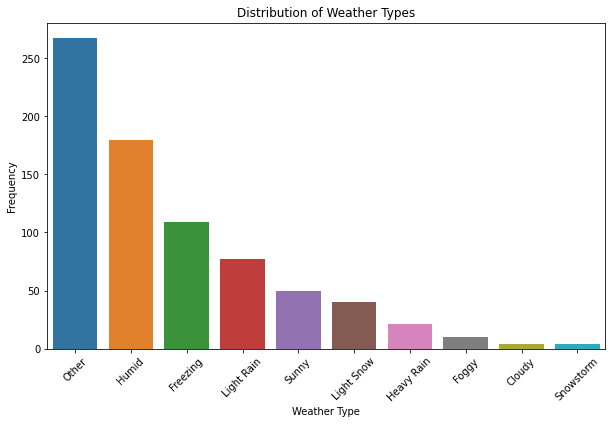

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pandas_df = final_df.toPandas()

#Calculate correlation matrix
corr = pandas_df[columns_to_convert].corr()

#Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Weather Variables')
plt.show()

#Temperature over time 
pandas_df['date'] = pd.to_datetime(pandas_df['date'])

plt.figure(figsize=(12, 6))
plt.plot(pandas_df['date'], pandas_df['avg_temperature'], label='Average Temperature')
plt.title('Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

#Distribution
weather_type_counts = pandas_df['weather_type'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=weather_type_counts.index, y=weather_type_counts.values)
plt.title('Distribution of Weather Types')
plt.xlabel('Weather Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [0]:
#Displaying the dataframe
display(final_df.groupBy("weather_type").count().orderBy("count", ascending=False))

weather_type,count
Other,267
Humid,179
Freezing,109
Light Rain,77
Sunny,50
Light Snow,40
Heavy Rain,21
Foggy,10
Cloudy,4
Snowstorm,4
